In [1]:
import iris
import pytz
from datetime import datetime, timedelta

from utilities import CF_names

stop = datetime(2014, 7, 7, 12)
stop = stop.replace(tzinfo=pytz.utc)
start = stop - timedelta(days=7)

bbox = [-87.40, 24.25, -74.70, 36.70]

name_list = CF_names['sea_water_temperature']

units = iris.unit.Unit('celsius')

In [2]:
import warnings
from utilities import quick_load_cubes, proc_cube, get_surface

url = ("http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his_Best/"
       "ESPRESSO_Real-Time_v2_History_Best_Available_best.ncd")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Suppress iris warnings.
    cube = quick_load_cubes(url, name_list, callback=None, strict=True)
    cube = proc_cube(cube, bbox=bbox, time=(start, stop), units=units)
    cube = get_surface(cube)  # Get a 2D surface cube.  I am working on 3D...

In [3]:
from utilities import get_nearest_water, make_tree

obs = dict(lon=-76.67, lat=34.72)

tree, lon, lat = make_tree(cube)
kw = dict(k=10, max_dist=0.04, min_var=0.01)
series, dist, idx = get_nearest_water(cube, tree, obs['lon'], obs['lat'], **kw)

In [4]:
print('Distance (degrees): {}'.format(dist))

print('Indices: {!r}'.format(idx))

Distance (degrees): 0.0365053546137
Indices: (21, 2)


In [5]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [6]:
import numpy.ma as ma


c = cube[-1, ...]  # Latest temperature.
c.data = ma.masked_invalid(c.data)

lon = c.coord(axis='X').points
lat = c.coord(axis='Y').points

extent = (lon.min(), lon.max(),
          lat.min(), lat.max())

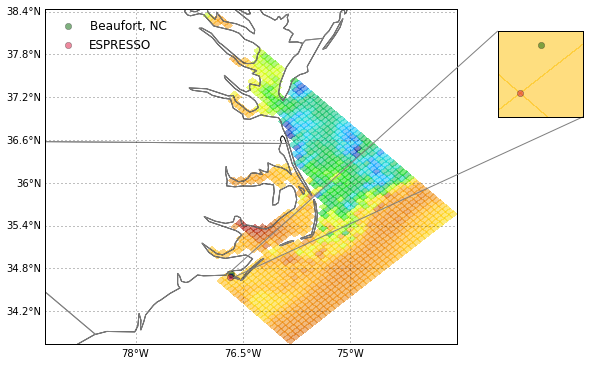

In [11]:
from oceans import cm

from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

fig, ax = make_map()
ax.set_extent(extent)
cs = ax.pcolormesh(lon, lat, c.data, cmap=cm.rscolmap, alpha=0.5)
ax.plot(obs['lon'], obs['lat'], 'o', color='darkgreen', label='Beaufort, NC', alpha=0.5)
ax.plot(lon[idx], lat[idx], 'o', color='crimson', label='ESPRESSO', alpha=0.5)
# ax.set_title(c.attributes['title'])
ax.add_feature(states, edgecolor='gray')
leg = ax.legend(numpoints=1, fancybox=True, framealpha=0, loc="upper left")

axins = zoomed_inset_axes(ax, 20, loc=5,
                         bbox_to_anchor=(1.1, 0.75),
                          bbox_transform=ax.figure.transFigure)
axins.pcolormesh(lon, lat, c.data, cmap=cm.rscolmap, alpha=0.5)
axins.plot(obs['lon'], obs['lat'], 'o', color='darkgreen', label='Beaufort, NC', alpha=0.5)
axins.plot(lon[idx], lat[idx], 'o', color='crimson', label='ESPRESSO', alpha=0.5)
axins.axis([-76.7, -76.64,
             34.67,  34.73])
mark_inset(ax, axins, loc1=2, loc2=4, ec="0.5")
axins.axes.get_xaxis().set_ticks([])
axins.axes.get_yaxis().set_ticks([])

fig.savefig("nearest.svg", bbox_inches='tight')

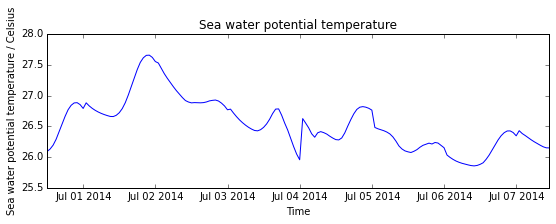

In [8]:
import iris.quickplot as qplt

fig, ax = plt.subplots(figsize=(9, 2.75))
l, = qplt.plot(series)